<a href="https://colab.research.google.com/github/MPGarg/Assignment-14/blob/main/EVA8_Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q --upgrade transformers diffusers ftfy
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00


In [2]:
!pip install accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.7 MB/s eta 0:00:00


In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

(…)fusion-v1-4/resolve/main/vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)h14/resolve/main/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

(…)tch14/resolve/main/tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

(…)t-large-patch14/resolve/main/config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

(…)usion-v1-4/resolve/main/unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# Functions

In [5]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [6]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [7]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 10            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

# Textual Inversion

In [8]:
prompt = 'an oil painting of a god .'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [9]:
# See the individual token
for t in text_input['input_ids'][0][:7]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(550) an</w>
tensor(2870) oil</w>
tensor(3086) painting</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(1731) god</w>


In [10]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

In [11]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))

In [12]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [13]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

## Without any Textual Inversion

0it [00:00, ?it/s]

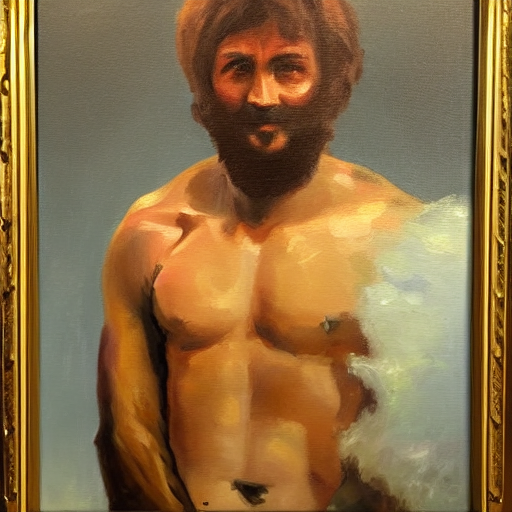

In [14]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

In [15]:
replace_id=269  #replaced dot with Textual Inversion

## midjourney-style

In [16]:
x_embed = torch.load('learned_embeds_m.bin')
x_embed.keys(), x_embed['<midjourney-style>'].shape

(dict_keys(['<midjourney-style>']), torch.Size([768]))

0it [00:00, ?it/s]

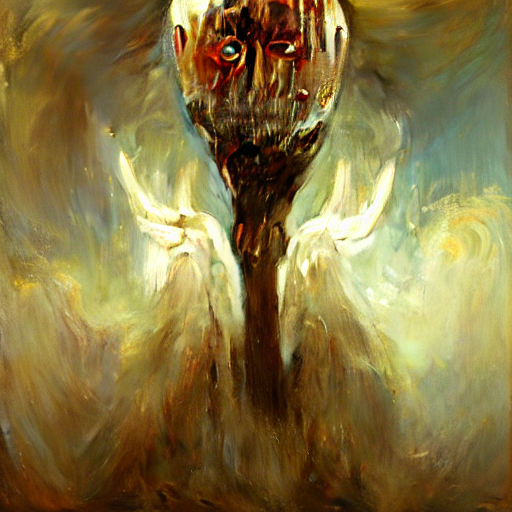

In [17]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<midjourney-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image1 = generate_with_embs(modified_output_embeddings)
image1

## hitokomoru-style

In [18]:
x_embed = torch.load('learned_embeds_h.bin')
x_embed.keys(), x_embed['<hitokomoru-style>'].shape

(dict_keys(['<hitokomoru-style>']), torch.Size([768]))

0it [00:00, ?it/s]

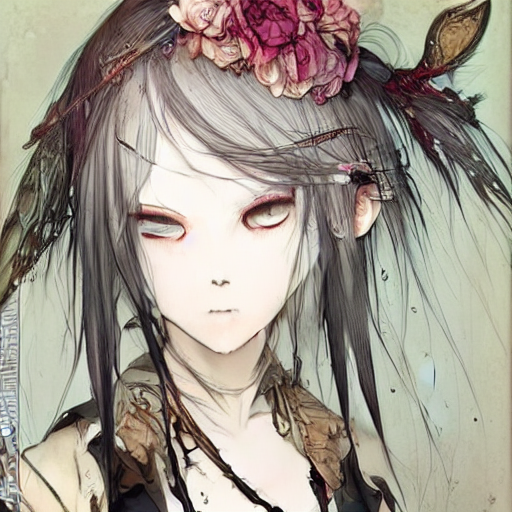

In [19]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<hitokomoru-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image2 = generate_with_embs(modified_output_embeddings)
image2

## birb-style

In [20]:
x_embed = torch.load('learned_embeds.bin')
x_embed.keys(), x_embed['<birb-style>'].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

0it [00:00, ?it/s]

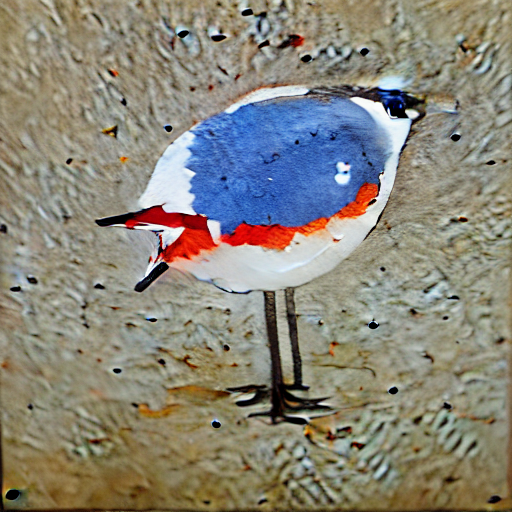

In [21]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image3 = generate_with_embs(modified_output_embeddings)
image3

## summie-style

In [22]:
x_embed = torch.load('learned_embeds_s.bin')
x_embed.keys(), x_embed['<summie-style>'].shape

(dict_keys(['<summie-style>']), torch.Size([768]))

0it [00:00, ?it/s]

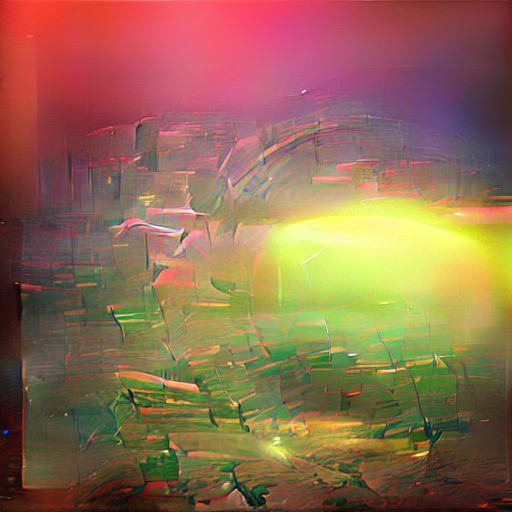

In [23]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<summie-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image4 = generate_with_embs(modified_output_embeddings)
image4

## simple-style

In [25]:
x_embed = torch.load('learned_embeds_ss.bin')
x_embed.keys(), x_embed['simple_style'].shape

(dict_keys(['simple_style']), torch.Size([768]))

0it [00:00, ?it/s]

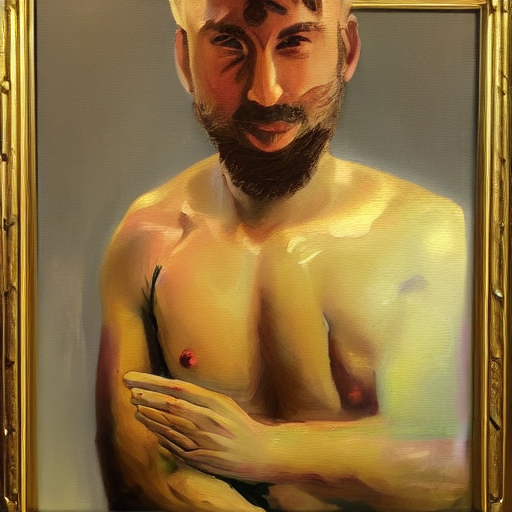

In [26]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['simple_style'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image5 = generate_with_embs(modified_output_embeddings)
image5

## m-geo

In [27]:
x_embed = torch.load('learned_embeds_mg.bin')
x_embed.keys(),x_embed['<m-geo>'].shape

(dict_keys(['<m-geo>']), torch.Size([768]))

0it [00:00, ?it/s]

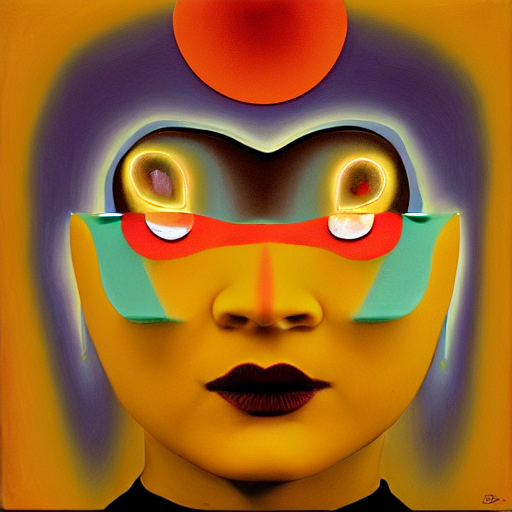

In [28]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<m-geo>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image6 = generate_with_embs(modified_output_embeddings)
image6

# Embedding of target using same model.
## Loss function is designed by comparing difference in generated image & target image

0it [00:00, ?it/s]

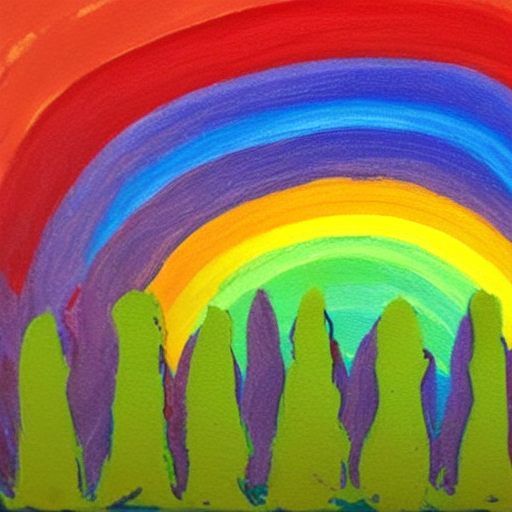

In [29]:
prompt1 = 'rainbow'

# Tokenize
text_input1 = tokenizer(prompt1, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings1 = pos_emb_layer(position_ids)

input_ids1 = text_input1.input_ids.to(torch_device)

# Get token embeddings
token_embeddings1 = token_emb_layer(input_ids1)

# Combine with pos embs
input_embeddings1 = token_embeddings1 + position_embeddings1

#  Feed through to get final output embs
modified_output_embeddings1 = get_output_embeds(input_embeddings1)

# And generate an image with this:
ref_image = generate_with_embs(modified_output_embeddings1)
ref_image

In [30]:
ref_latent = pil_to_latent(ref_image)

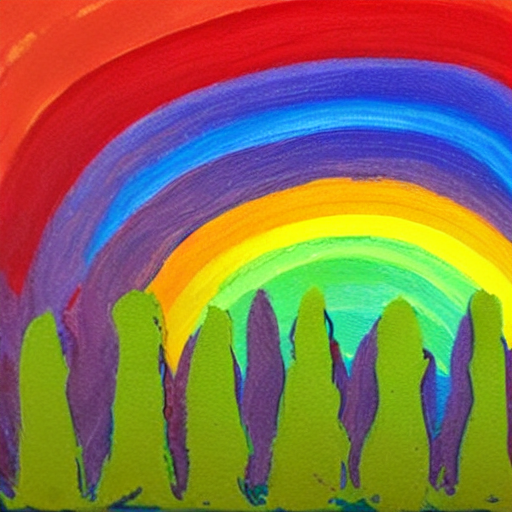

In [31]:
latents_to_pil(ref_latent)[0]

## Loss Function

In [32]:
def ref_loss(images,ref_image):
    # Reference image
    error = torch.abs(images - ref_image).mean()
    return error

In [33]:
print(ref_image)

<PIL.Image.Image image mode=RGB size=512x512 at 0x7AD1F81B1600>


# Image Generation using loss function

0it [00:00, ?it/s]

0 loss: 53.75627136230469
10 loss: 46.40673065185547


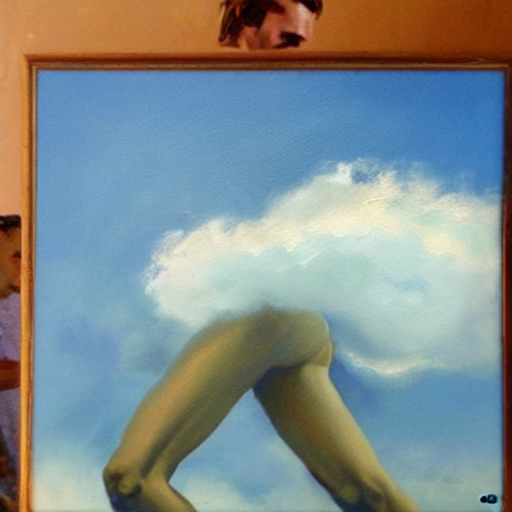

In [34]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 20  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1


    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    #latents = scheduler.step(noise_pred, t, latents).pred_original_sample


latents_to_pil(latents)[0]

In [35]:
x_embed = torch.load('learned_embeds_m.bin')
x_embed.keys()

dict_keys(['<midjourney-style>'])

0it [00:00, ?it/s]

0 loss: 58.353858947753906
10 loss: 51.384944915771484
20 loss: 42.74883270263672
30 loss: 39.921875
40 loss: 39.12974166870117


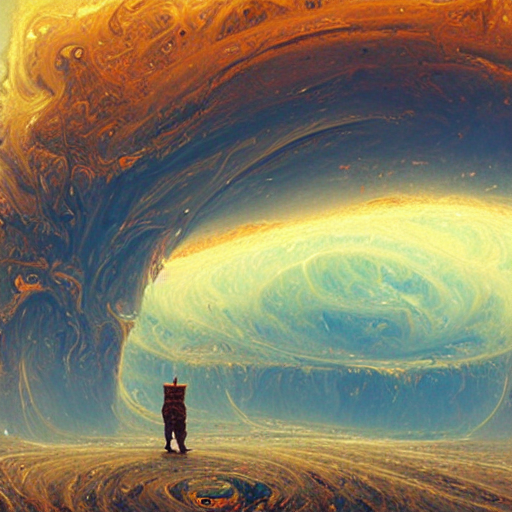

In [36]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<midjourney-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [37]:
x_embed = torch.load('learned_embeds_h.bin')
x_embed.keys()

dict_keys(['<hitokomoru-style>'])

0it [00:00, ?it/s]

0 loss: 69.08203887939453
10 loss: 61.304683685302734
20 loss: 52.622772216796875
30 loss: 49.68070983886719
40 loss: 50.46160125732422


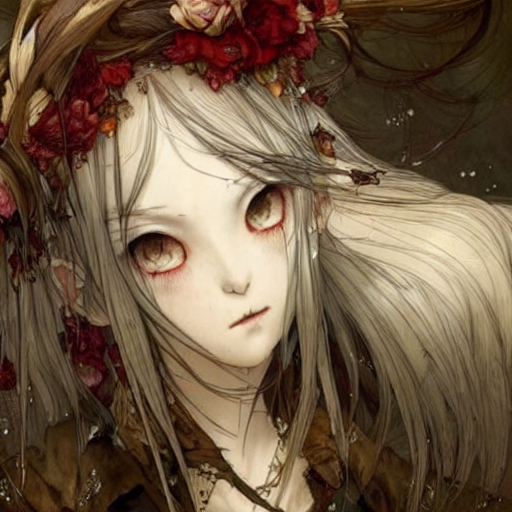

In [38]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<hitokomoru-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [39]:
x_embed = torch.load('learned_embeds.bin')
x_embed.keys()

dict_keys(['<birb-style>'])

0it [00:00, ?it/s]

0 loss: 56.188560485839844
10 loss: 46.16401290893555
20 loss: 41.00862503051758
30 loss: 40.223876953125
40 loss: 39.885650634765625


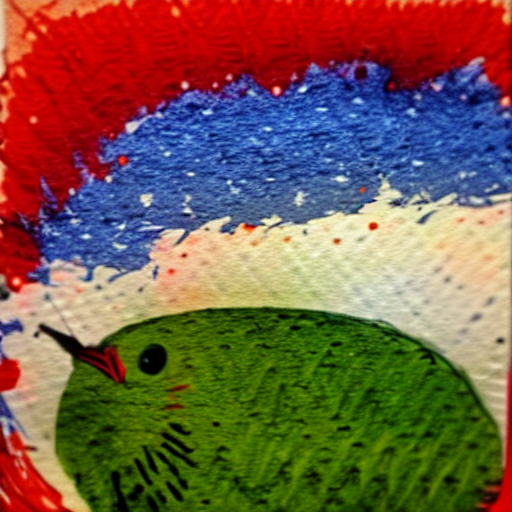

In [40]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [41]:
x_embed = torch.load('learned_embeds_s.bin')
x_embed.keys(), x_embed['<summie-style>'].shape

(dict_keys(['<summie-style>']), torch.Size([768]))

0it [00:00, ?it/s]

0 loss: 48.02013397216797
10 loss: 46.26024627685547
20 loss: 38.83173370361328
30 loss: 36.24291229248047
40 loss: 35.51671600341797


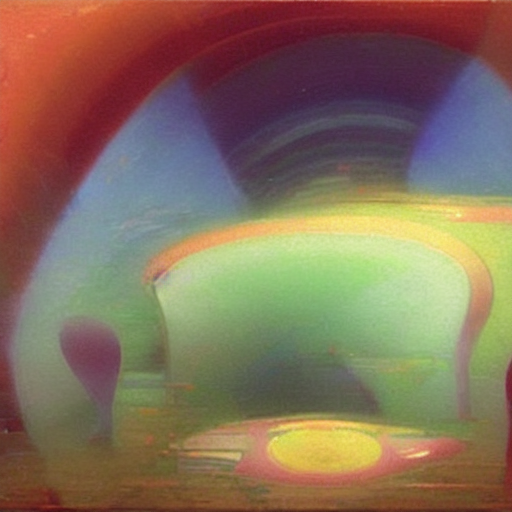

In [42]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<summie-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [43]:
x_embed = torch.load('learned_embeds_i.bin')
x_embed.keys()

dict_keys(['<illustration-style>'])

0it [00:00, ?it/s]

0 loss: 62.845027923583984
10 loss: 42.377864837646484
20 loss: 39.39912414550781
30 loss: 39.47115707397461
40 loss: 39.18617248535156


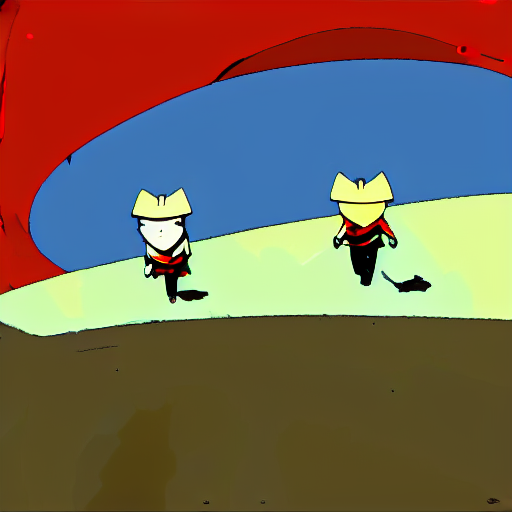

In [44]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<illustration-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [45]:
x_embed = torch.load('learned_embeds_mg.bin')
x_embed.keys()

dict_keys(['<m-geo>'])

0it [00:00, ?it/s]

0 loss: 61.77875518798828
10 loss: 36.792179107666016
20 loss: 33.96669387817383
30 loss: 32.706871032714844
40 loss: 31.928312301635742


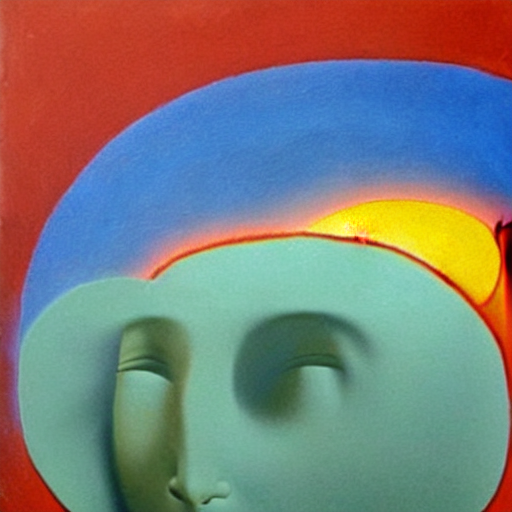

In [46]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<m-geo>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [47]:
x_embed = torch.load('learned_embeds_ss.bin')
x_embed.keys()

dict_keys(['simple_style'])

0it [00:00, ?it/s]

0 loss: 50.300758361816406
10 loss: 45.118736267089844
20 loss: 41.52873229980469
30 loss: 40.28135299682617
40 loss: 40.12013626098633


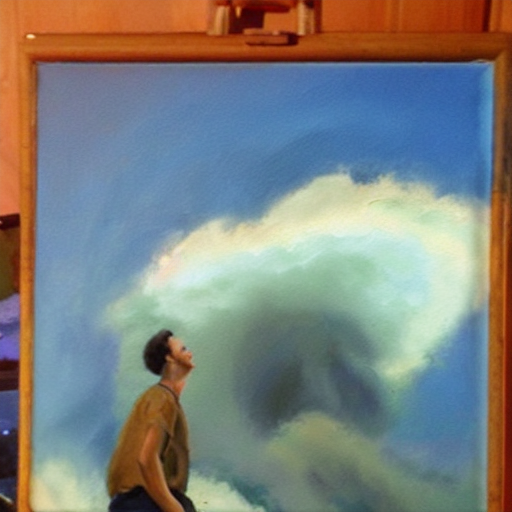

In [48]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['simple_style'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]